# Horizontal Regridding

Author: [Jason Boutte](https://github.com/jasonb5)

Updated: 11/07/24 [xcdat v0.7.3]

Related APIs:

- [xarray.Dataset.regridder.horizontal](../generated/xarray.Dataset.regridder.horizontal.rst)

## Other Resources

- [xESMF documentation](https://xesmf.readthedocs.io/en/latest/)

## Overview

We'll cover horizontal regridding using the `xESMF` and `Regrid2` tools as well as various methods supported by `xESMF`.

It should be noted that `Regrid2` treats the grid cells as being flat.

In the example below, we will be working with the `"ersstv5"` dataset (NOAA’s Extended Reconstructed Sea Surface Temperature monthly averages). The data used in this example can be found in the [xarray-data repository](https://github.com/pydata/xarray-data).


### Notebook Kernel Setup

Users can [install their own instance of xcdat](../getting-started-guide/installation.rst) and follow these examples using their own environment (e.g., with VS Code, Jupyter, Spyder, iPython) or [enable xcdat with existing JupyterHub instances](../getting-started-guide/getting-started-hpc-jupyter.rst).

First, create the conda environment:

```bash
conda create -n xcdat_notebook -c conda-forge xcdat xesmf matplotlib ipython ipykernel cartopy nc-time-axis gsw-xarray jupyter pooch
```

Then install the kernel from the `xcdat_notebook` environment using `ipykernel` and name the kernel with the display name (e.g., `xcdat_notebook`):

```bash
python -m ipykernel install --user --name xcdat_notebook --display-name xcdat_notebook
```

Then to select the kernel `xcdat_notebook` in Jupyter to use this kernel.


In [1]:
# %matplotlib inline
import os
import sys

import matplotlib.pyplot as plt
import xarray as xr
import xcdat as xc
import xesmf

## 1. Open the Dataset

We are using xarray's OPeNDAP support to read a netCDF4 dataset file directly from its source. The data is not loaded over the network until we perform operations on it (e.g., temperature unit adjustment).

More information on the xarray's OPeNDAP support can be found [here](https://docs.xarray.dev/en/stable/user-guide/io.html#opendap).


In [2]:
ds = xc.tutorial.open_dataset("ersstv5", use_cftime=True)

ds

<xarray.Dataset> Size: 40MB
Dimensions:    (lat: 89, lon: 180, time: 624, bnds: 2)
Coordinates:
  * lat        (lat) float32 356B 88.0 86.0 84.0 82.0 ... -84.0 -86.0 -88.0
  * lon        (lon) float32 720B 0.0 2.0 4.0 6.0 ... 352.0 354.0 356.0 358.0
  * time       (time) object 5kB 1970-01-01 00:00:00 ... 2021-12-01 00:00:00
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object 10kB 1970-01-01 00:00:00 ... 2022-01-01 00...
    sst        (time, lat, lon) float32 40MB ...
    lon_bnds   (lon, bnds) float32 1kB -1.0 1.0 1.0 3.0 ... 357.0 357.0 359.0
    lat_bnds   (lat, bnds) float32 712B 89.0 87.0 87.0 ... -87.0 -87.0 -89.0
Attributes: (12/37)
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermometer...
    ...                        ...
    creator_url_original:      https://www.ncei.noaa.gov
    license:                   No constraints on data access or use
    comment:                   SSTs were observed by conventional thermometer...
    summary:                   ERSST.v5 is developed based on v4 after revisi...
    dataset_title:             NOAA Extended Reconstructed SST V5
    data_modified:             2022-06-07

## 2. Create the output grid

Related API: [xcdat.create_gaussian_grid()](../generated/xcdat.create_gaussian_grid.rst)

In this example, we will generate a gaussian grid with 32 latitudes to regrid our input data to.

Alternatively a grid can be loaded from an `.nc` file.

Other related APIs available for creating grids: [xcdat.create_grid()](../generated/xcdat.create_grid.rst) and [xcdat.create_uniform_grid()](../generated/xcdat.create_uniform_grid.rst)


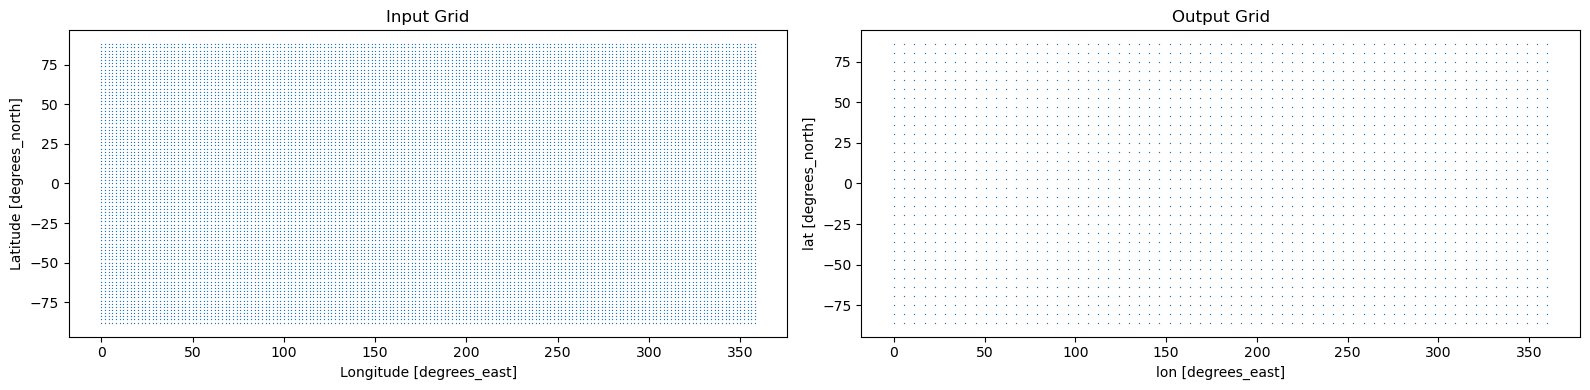

In [3]:
output_grid = xc.create_gaussian_grid(32)

fig, axes = plt.subplots(ncols=2, figsize=(16, 4))

ds.regridder.grid.plot.scatter(x="lon", y="lat", s=4, ax=axes[0])
axes[0].set_title("Input Grid")

output_grid.plot.scatter(x="lon", y="lat", s=4, ax=axes[1])
axes[1].set_title("Output Grid")

plt.tight_layout()

## 3. Regrid the data

Related API: [xarray.Dataset.regridder.horizontal()](../generated/xarray.Dataset.regridder.horizontal.rst)

Here we will regrid the input data to the ouptut grid using the `xESMF` tool and the `bilinear` method.


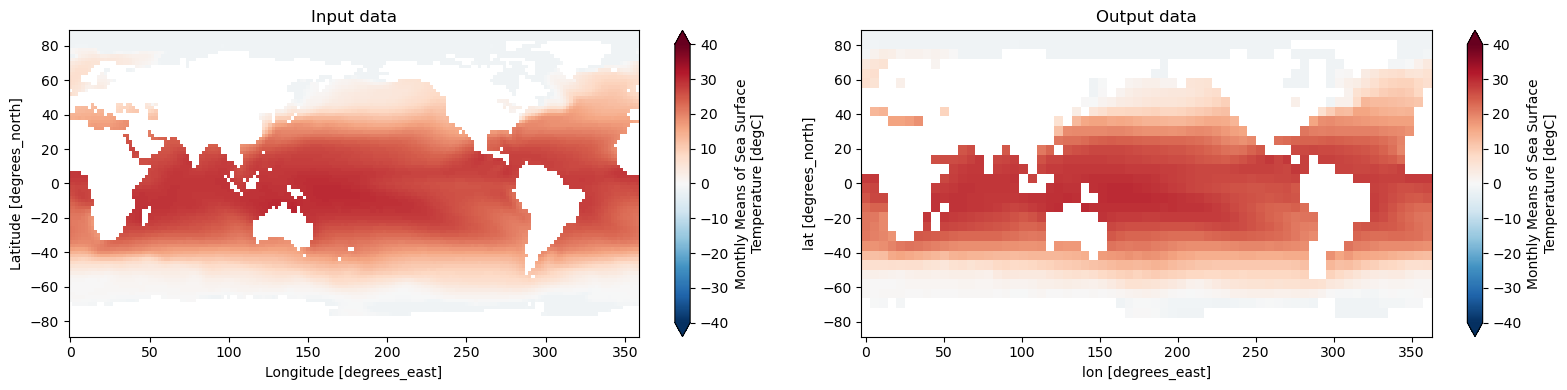

In [4]:
output = ds.regridder.horizontal("sst", output_grid, tool="xesmf", method="bilinear")

fig, axes = plt.subplots(ncols=2, figsize=(16, 4))

ds.sst.isel(time=0).plot(ax=axes[0], vmin=-40, vmax=40, extend="both", cmap="RdBu_r")
axes[0].set_title("Input data")

output.sst.isel(time=0).plot(
    ax=axes[1], vmin=-40, vmax=40, extend="both", cmap="RdBu_r"
)
axes[1].set_title("Output data")

plt.tight_layout()

## 4. Regridding algorithms

Related API: [xarray.Dataset.regridder.horizontal()](../generated/xarray.Dataset.regridder.horizontal.rst)

In this example, we will compare the different regridding methods supported by `xESMF`.

You can find a more in depth comparison on `xESMF`'s [documentation](https://xesmf.readthedocs.io/en/latest/notebooks/Compare_algorithms.html).

Methods:

- bilinear
- conservative
- nearest_s2d
- nearest_d2s
- patch


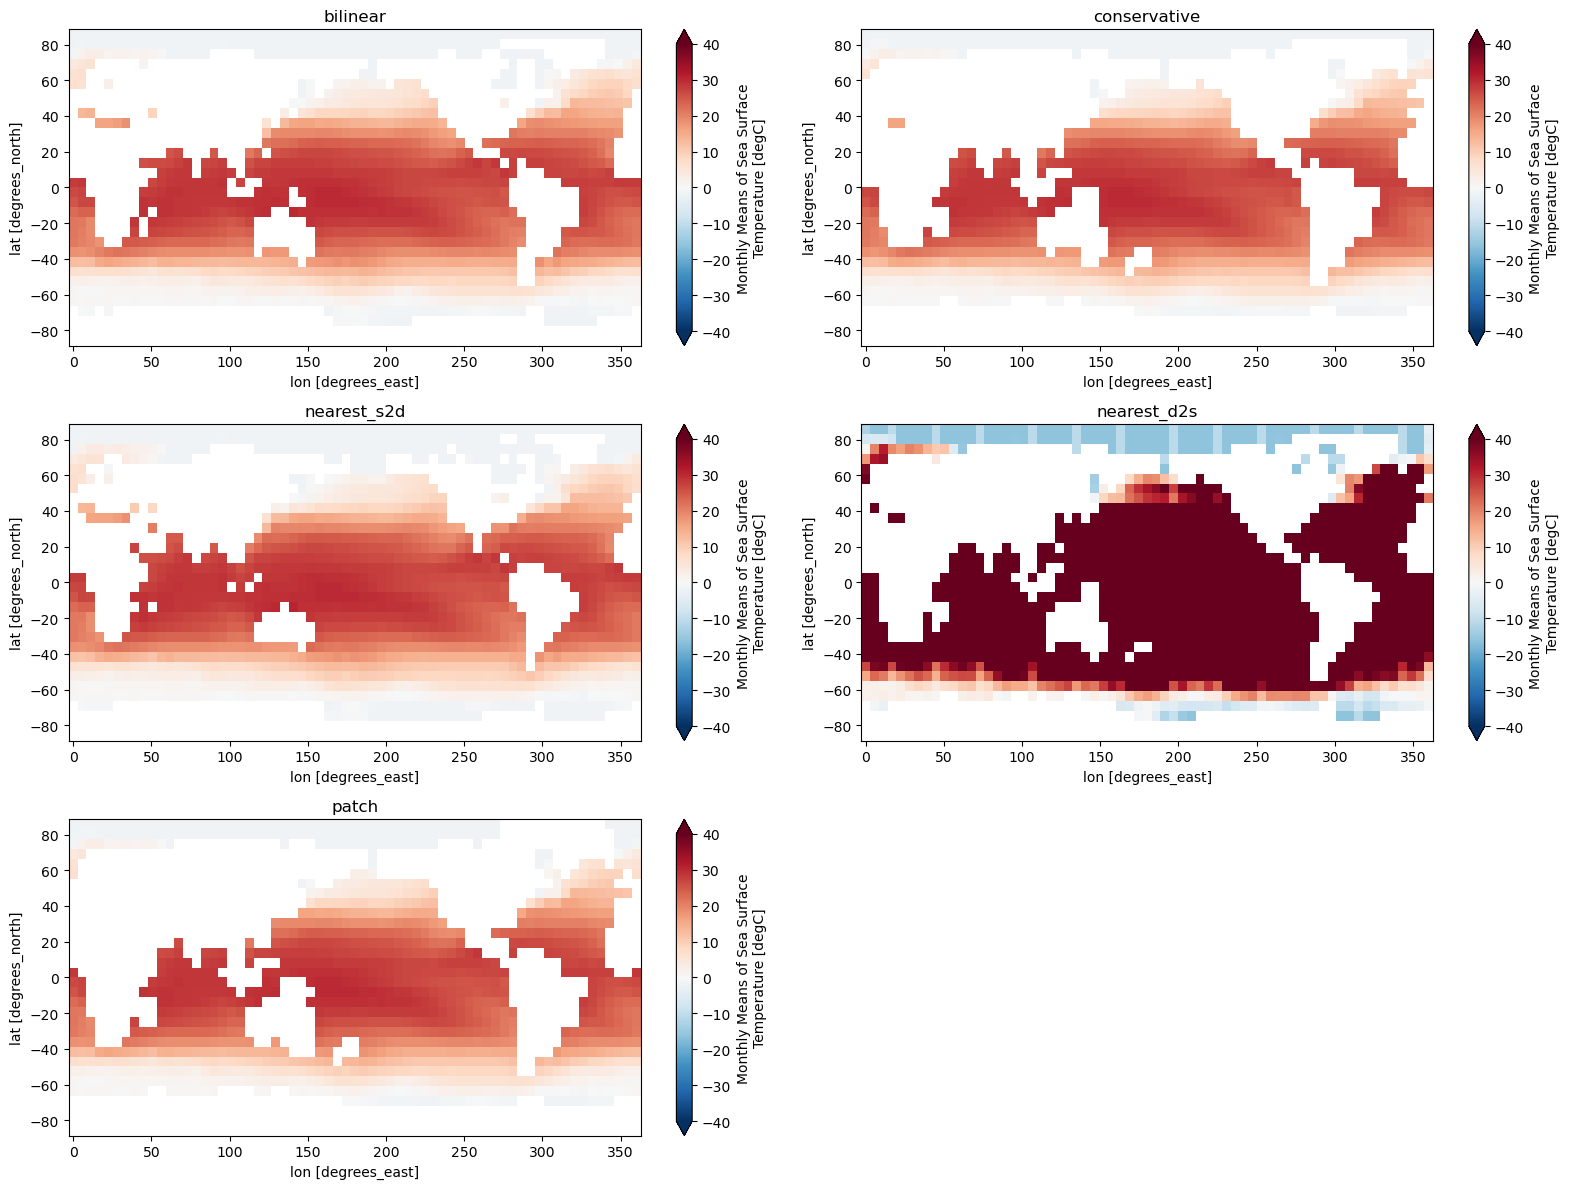

In [5]:
methods = ["bilinear", "conservative", "nearest_s2d", "nearest_d2s", "patch"]

fig, axes = plt.subplots(3, 2, figsize=(16, 12))

axes = axes.flatten()

for i, method in enumerate(methods):
    output = ds.regridder.horizontal("sst", output_grid, tool="xesmf", method=method)

    output.sst.isel(time=0).plot(
        ax=axes[i], vmin=-40, vmax=40, extend="both", cmap="RdBu_r"
    )

    axes[i].set_title(method)

axes[-1].set_visible(False)

plt.tight_layout()

## 5. Masking

Related API: [xarray.Dataset.regridder.horizontal()](../generated/xarray.Dataset.regridder.horizontal.rst)

`xESMF` supports masking by simply adding a data variable with the id `mask`.

See `xESMF` [documentation](https://pangeo-xesmf.readthedocs.io/en/latest/notebooks/Masking.html) for additonal details.


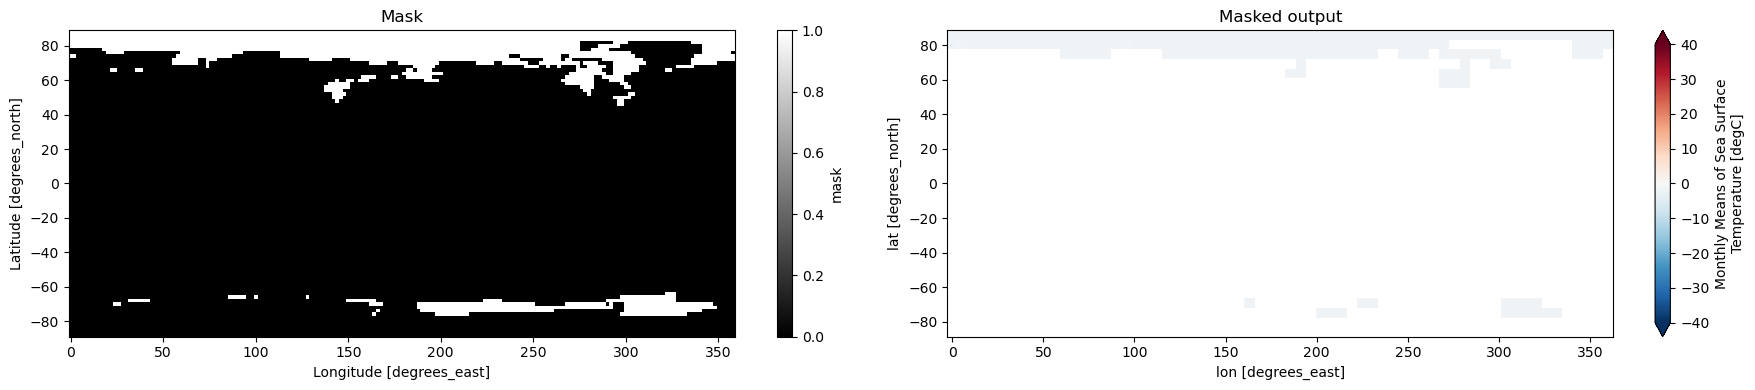

In [6]:
# FIXME: Fix the mask here for this variable.
ds["mask"] = xr.where(ds.sst.isel(time=0) < -1, 1, 0)

masked_output = ds.regridder.horizontal(
    "sst", output_grid, tool="xesmf", method="bilinear"
)

fig, axes = plt.subplots(ncols=2, figsize=(18, 4))

ds["mask"].plot(ax=axes[0], cmap="binary_r")
axes[0].set_title("Mask")

masked_output.sst.isel(time=0).plot(
    ax=axes[1], vmin=-40, vmax=40, extend="both", cmap="RdBu_r"
)
axes[1].set_title("Masked output")

plt.tight_layout()

## 6. Regridding using `regrid2`

Related API: [xarray.Dataset.regridder.horizontal()](../generated/xarray.Dataset.regridder.horizontal.rst)

`Regrid2` is a conservative regridder for rectilinear (lat/lon) grids originally from the `cdutil` package from `CDAT`.

This regridder assumes constant latitude lines when generating weights.


/global/u2/v/vo13/xCDAT/xcdat/xcdat/regridder/regrid2.py:196: RuntimeWarning: invalid value encountered in divide
  np.divide(


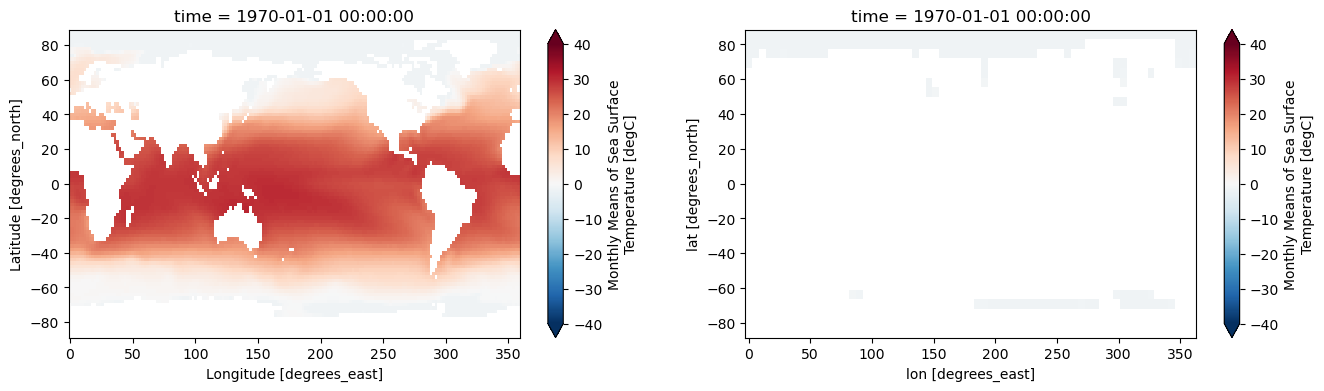

In [8]:
# FIXME: Fix the regrid2 example not showing anything on the plot.
output = ds.regridder.horizontal("sst", output_grid, tool="regrid2")

fig, axes = plt.subplots(ncols=2, figsize=(16, 4))

ds.sst.isel(time=0).plot(ax=axes[0], vmin=-40, vmax=40, extend="both", cmap="RdBu_r")

output.sst.isel(time=0).plot(
    ax=axes[1], vmin=-40, vmax=40, extend="both", cmap="RdBu_r"
)